# Imports 

In [1]:
import pickle
import pandas as pd
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import numpy as np
from tqdm import tqdm


# MODEL PACKAGES
    #SKLEARN
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from statsmodels.tsa.x13 import x13_arima_analysis as x13
from sklearn.metrics import max_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor
# CUSTOM FUNCTIONS

import os
import sys
currentdir = os.path.dirname(os.path.realpath('analysis_DK'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)


from func import (chunks, reindex, global_id, term_list, time_corr_plot, rmse, time_variable_plot, find_highest_corr, test_train_split,
                  bootstrap_all_windows, bootstrap_n_samples, bootstrap_sample, final_model, final_model_boot, ar_1, grid_bestpar, tuning_window, tuning_window_mp, tuning_window_bestpar,
                  model_tuning, seasadj, seasadj_col_list, abs_percentage_change, add_poly_terms, create_interaction, test_train_split_Q)

In [82]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 12})
rc('text', usetex=True)

# Results and score dataframes

## Loading results

In [2]:
# BASELINE
# with open('results/final/baseline/results_baseline.pickle', 'rb') as handle:
#     results_baseline = pickle.load(handle)
with open('results/final/baseline/results_baseline_ar1.pickle', 'rb') as handle:
    results_baseline = pickle.load(handle)

#LASSO
with open('results/final/lasso/results_final.pickle', 'rb') as handle:
    results_lasso = pickle.load(handle) 

#RIDGE
with open('results/final/ridge/results_final.pickle', 'rb') as handle:
    results_ridge = pickle.load(handle) 

# #ELASTIC
with open('results/final/elastic/results_final.pickle', 'rb') as handle:
    results_elastic = pickle.load(handle) 
    
# #RANDOM FOREST
with open('results/final/randomforest/results_final_no_int.pickle', 'rb') as handle:
    results_randomforest = pickle.load(handle) 

#XGBOOST
with open('results/final/xgboost/results_final_noint.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)
# with open('results/final/xgboost/results_final_shap.pickle', 'rb') as handle:
#     results_xgboost = pickle.load(handle)
    

#WEIGHTED
with open('results/final/weighted/results_final.pickle', 'rb') as handle:
    results_weighted = pickle.load(handle)
#Adding nan so lenghts match
results_weighted[1] = {'w': np.nan,
 'best_rmse': np.nan,
 'y_pred': np.nan,
 'best_y_pred_rmse': np.nan,
 'y_actual': np.nan}


# TEST DATES FOR EACH WINDOW
with open('results/final/y_dates.pickle', 'rb') as handle:
    y_dates = pickle.load(handle)

## ML - Data and preprocessing 

### Import data frame with adjusted here

In [3]:
#Loading adjusted df_analysis
df_analysis = pd.read_csv('data/df_DK.csv', sep = ',', parse_dates = ['date'])

### Initial preprocessing and feature construction

- Create dummies 
- Create interaction terms

Overall monthly time trend variable, $t=1,2...,T$ within `ID` variable:

In [4]:
#Temp container
temp = {}

for i in df_analysis['ID'].unique():
    temp[i] = df_analysis[df_analysis['ID']==i]
    temp[i]['t'] = range(1, len(temp[i]['ID'])+1)

#Concatting the df's
temp = pd.concat(temp, ignore_index=True, sort = False)

#Merging onto analysis
df_analysis = pd.merge(left = df_analysis, right = temp[['date', 'ID', 't']], left_on =['date', 'ID'], right_on = ['date', 'ID'])

C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Drop sector variables

In [5]:
df_analysis.drop(['sector_sales_communication', 'sector_other'], axis = 1, inplace=True)

#### Dropping socioeconomic index

In [6]:
df_analysis.drop(['w_ave_socio_index', 'target_lag'], axis = 1, inplace = True)

#### Transform relevant columns to abs change exept those with M_ and ID_, date and t

In [7]:
df_analysis['target_actual'] = df_analysis.groupby(['ID'])['target_actual'].diff()

### Lagged variables

In [8]:
df_analysis['target_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(1)

In [9]:
df_analysis['target_12_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(12)

#### Create new variables with 3 month lag of jobrate

In [10]:
columns_3m_lag = ['jobs', 'sector_information_technology', 'sector_engineering_technology',
                   'sector_management_staff', 'sector_trade_service', 'sector_industry_craft',
                   'sector_teaching', 'sector_office_finance', 'sector_social_health']

for colname in columns_3m_lag:
    df_analysis[str(colname + '_3_lag')] = df_analysis.groupby(['ID'])[colname].shift(3)

#### Dropping some GT variables

In [11]:
# Dropping some GT's
drop_list = ['GT_DK_1', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_8', 'GT_DK_11', 'GT_DK_13', 'GT_DK_15', 'GT_DK_16', 'GT_DK_18', 'GT_DK_19', 'GT_DK_21']

In [12]:
df_analysis.drop(drop_list, axis = 1, inplace=True)

#### Create new variables with 1 month lag of GT

In [13]:
columns_1m_lag = ['GT_DK_0', 'GT_DK_2', 'GT_DK_3', 'GT_DK_7', 'GT_DK_9', 'GT_DK_10', 'GT_DK_12', 'GT_DK_14', 'GT_DK_17', 'GT_DK_20']
for colname in columns_1m_lag:
    df_analysis[str(colname + '_1_lag')] = df_analysis.groupby(['ID'])[colname].shift(1)

#### Month dummies for season effects

In [14]:
df_analysis['month'] = pd.DatetimeIndex(df_analysis['date']).month.astype(str)

#### Creating dummies from categorial variables - remember to drop the reference category (done after change is constructed)

In [15]:
df_analysis = pd.get_dummies(df_analysis, prefix=['ID','M'], prefix_sep='_', columns=['ID', 'month']).copy()

#### Drop na

In [16]:
df_analysis.dropna(inplace=True)

In [17]:
df_analysis.date.min()

Timestamp('2008-03-01 00:00:00')

#### Adding interaction terms

Polynominal features - To be deleted later

In [18]:
#df_analysis = add_poly_terms(df = df_analysis, 
#                            poly_columns = ['target_actual', 'GT_0', 'GT_1', 'GT_2', 'GT_3', 'GT_4', 'GT_5', 'GT_6', 'GT_7', 'GT_8', 'GT_9', 'GT_10', 'GT_11', 'GT_12', 'GT_13', 'GT_14', 'GT_15', 'GT_16', 'GT_17', 'GT_18', 'GT_19', 'target_lag', 'jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'])

In [19]:
#df_analysis.dropna(inplace=True)

Adding interaction terms by regions and all variables

In [20]:
# # relevant interaction variables
# interaction_1 = ['target_lag', 'target_12_lag'] 
# # 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'

# # get list of all ID area 
# interaction_2 = [item for item in df_analysis if item.startswith('ID_')]

In [21]:
# for var1 in interaction_1:
#     for var2 in interaction_2:
#         name = var1 + "*" + var2
#         df_analysis[name] = pd.Series(df_analysis[var1] * df_analysis[var2], name=name)

#### Drop variables to not end up in dummytrap

In [22]:
df_analysis = df_analysis.drop(['ID_Capital', 'M_1'], axis = 1)

In [23]:
# df_analysis.drop(interaction_1, axis = 1, inplace=True)

In [24]:
df_analysis.sort_index(axis=1, inplace=True)

#### Setting window size

In [25]:
window = 35
testsize = 1
valsize = 1
rolling_window = True

In [26]:
X_train, X_val, X_test, y_train, y_val, y_test, dates = test_train_split(df = df_analysis, window = window, testsize=testsize, valsize = valsize,
                                                                  y_col='target_actual', rolling_window = rolling_window, df_output= False)

In [27]:
#Concatting val and train
for win in X_train.keys():
    X_train[win] = np.concatenate((X_train[win], X_val[win])).copy()
    y_train[win] = np.concatenate((y_train[win], y_val[win])).copy()

Standardizing features for each window

In [28]:
for win in X_train.keys():
    sc = StandardScaler()
    X_train[win] = sc.fit_transform(X_train[win])
    X_test[win] = sc.transform(X_test[win])

In [29]:
X_cols = df_analysis.drop(['target_actual', 'date'], axis = 1).copy()

# SHAP

In [41]:
import shap
from xgboost import XGBRegressor

In [31]:
shap.initjs()

### SHAP loops

In [32]:
#Initialising df
df_shap = pd.DataFrame(X_cols.columns)
df_shap.rename({0:'feature'}, axis = 1, inplace = True)

for win in tqdm(X_train.keys()):
    
#     CREATING MODEL OBJECT - XGBOOST
#     n_estimators = results_xgboost[win]['best_rmse'][0][1]
#     max_depth = results_xgboost[win]['best_rmse'][0][2]
#     colsample_bytree = results_xgboost[win]['best_rmse'][0][3]
#     gamma = results_xgboost[win]['best_rmse'][0][4]
#     subsample = results_xgboost[win]['best_rmse'][0][5]
#     min_child_weight = results_xgboost[win]['best_rmse'][0][6]

#     model = XGBRegressor(objective ='reg:squarederror', 
#                                             colsample_bytree = colsample_bytree, 
#                                             learning_rate = 0.1,
#                                             max_depth = max_depth,
#                                             n_estimators = n_estimators,
#                                             gamma = gamma,
#                                             subsample = subsample,
#                                             min_child_weight = min_child_weight,
#                                             n_jobs = -1,
#                                             seed = 1)

    #CREATING MODEL OBJECT - RANDOM FOREST
    n_estimators = results_randomforest[win]['best_rmse'][0][1]
    max_depth = results_randomforest[win]['best_rmse'][0][2]
    max_features = results_randomforest[win]['best_rmse'][0][3]
    min_samples_split = results_randomforest[win]['best_rmse'][0][4]
    min_samples_leaf = results_randomforest[win]['best_rmse'][0][5]

    #RUNNING THE MODEL
    model = RandomForestRegressor(n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    max_features =  max_features,
                                    min_samples_split = min_samples_split,
                                    min_samples_leaf = min_samples_leaf,
                                    bootstrap=True,
                                    n_jobs=-1,
                                    random_state=1)

    model.fit(X_train[win], y_train[win])

    y_pred = model.predict(X_test[win])

    par_rmse = rmse(y_pred.round(2), y_true= y_test[win])
    
    
    #SHAP VALUES FOR TEST
    shap_explainer = shap.TreeExplainer(model)
    shap_values = shap_explainer.shap_values(X_test[win])
    
    df_shap['win '+ str(win)] = pd.DataFrame(shap_values).apply(np.abs).mean()

100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:29<00:00,  3.48it/s]


In [33]:
df_shap.set_index('feature', inplace = True)

In [34]:
df_shap.columns

Index(['win 1', 'win 2', 'win 3', 'win 4', 'win 5', 'win 6', 'win 7', 'win 8',
       'win 9', 'win 10',
       ...
       'win 94', 'win 95', 'win 96', 'win 97', 'win 98', 'win 99', 'win 100',
       'win 101', 'win 102', 'win 103'],
      dtype='object', length=103)

In [35]:
df_shap['win 1'].idxmax()

'target_lag'

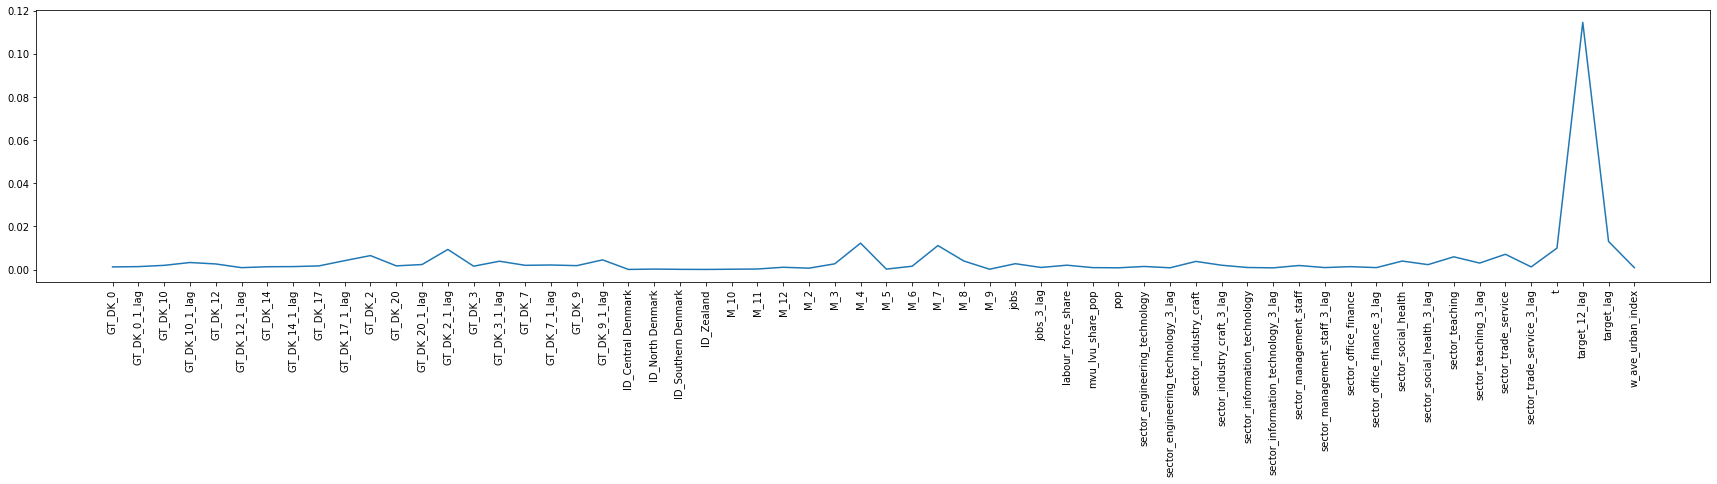

In [36]:
fig, ax = plt.subplots(figsize = (30,5))
ax.plot(df_shap.transpose().mean())

plt.xticks(rotation='vertical')

plt.show()

In [37]:
df_shap.transpose().mean()

feature
GT_DK_0                                0.001259
GT_DK_0_1_lag                          0.001390
GT_DK_10                               0.001984
GT_DK_10_1_lag                         0.003291
GT_DK_12                               0.002635
GT_DK_12_1_lag                         0.000919
GT_DK_14                               0.001336
GT_DK_14_1_lag                         0.001403
GT_DK_17                               0.001719
GT_DK_17_1_lag                         0.004162
GT_DK_2                                0.006501
GT_DK_20                               0.001745
GT_DK_20_1_lag                         0.002364
GT_DK_2_1_lag                          0.009358
GT_DK_3                                0.001586
GT_DK_3_1_lag                          0.003893
GT_DK_7                                0.001992
GT_DK_7_1_lag                          0.002147
GT_DK_9                                0.001843
GT_DK_9_1_lag                          0.004518
ID_Central Denmark              

### Collapsing

In [38]:
df_shap = df_shap.transpose().copy()

In [39]:
for GT in ['GT_DK_0',  'GT_DK_10', 'GT_DK_12', 'GT_DK_14', 'GT_DK_17','GT_DK_2', 'GT_DK_20', 'GT_DK_3',  'GT_DK_7', 'GT_DK_9']:
    df_shap[GT] = df_shap[GT] + df_shap[GT+'_1_lag']

df_shap.drop([GT+'_1_lag' for GT in ['GT_DK_0',  'GT_DK_10', 'GT_DK_12', 'GT_DK_14', 'GT_DK_17','GT_DK_2', 'GT_DK_20', 'GT_DK_3',  'GT_DK_7', 'GT_DK_9']], axis = 1, inplace = True)

for job in ['jobs', 'sector_engineering_technology','sector_industry_craft','sector_information_technology', 'sector_management_staff', 'sector_office_finance', 'sector_social_health', 'sector_teaching', 'sector_trade_service']:
    df_shap[job] = df_shap[job] + df_shap[job+'_3_lag']

df_shap.drop([job+'_3_lag' for job in ['jobs', 'sector_engineering_technology','sector_industry_craft','sector_information_technology', 'sector_management_staff', 'sector_office_finance', 'sector_social_health', 'sector_teaching', 'sector_trade_service']], axis = 1, inplace = True)

In [40]:
df_shap = df_shap.transpose().copy()

### Figure

In [41]:
drop_list = ['ID_Central Denmark', 'ID_North Denmark',
       'ID_Southern Denmark', 'ID_Zealand', 'M_10', 'M_11', 'M_12', 'M_2',
       'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 't',
             'w_ave_urban_index', 'labour_force_share', 'mvu_lvu_share_pop', 
             'pop','target_12_lag', 'target_lag'
            ]

In [42]:
sort_list = list(df_shap.drop(drop_list).transpose().mean().sort_values(ascending=False).index)

In [43]:
ylabels = ['Job openings', 'Jobs: Teaching', 'Jobs: Trade and service', 'Jobnet', 'Jobs: Social and healthcare', '3F',
           'Jobs: Industry and crafts', 'Jobcentre', 'Unemployment insurance fund', 'Jobindex', 'KRIFA',
          'Total jobs', 'Unemployment insurance rate', 'Jobs: Management and staff', 'ASE', 'Cash benefits', 'Jobs: Engineering techonology',
          'Jobs: Office and finance', 'Jobs: Information technology']

In [76]:
xlabels = ['2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01']

In [78]:
xlabels = [i[0:7].replace('-', 'M') for i in xlabels]

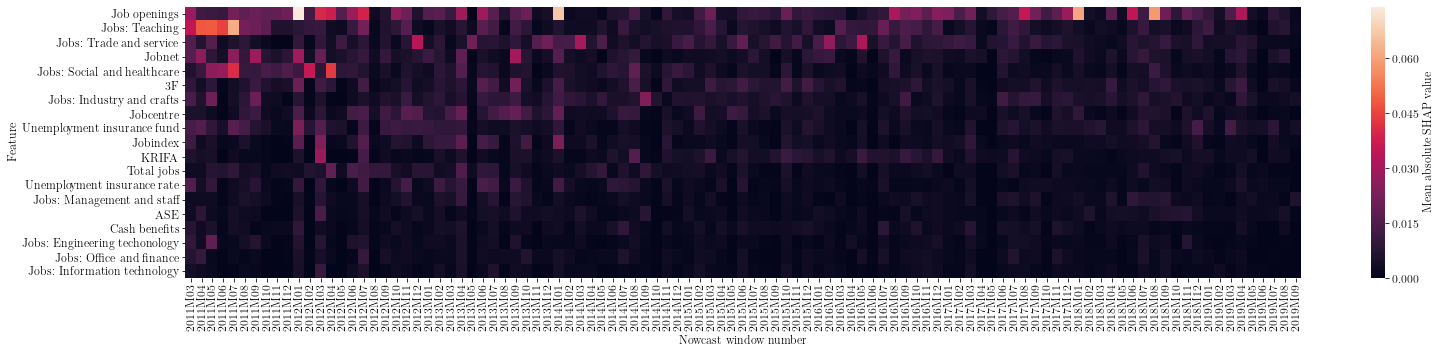

In [81]:
fig, ax = plt.subplots(figsize = (25,5))
sns.heatmap(df_shap.drop(drop_list).reindex(sort_list), cbar_kws={'label': 'Mean absolute SHAP value'}, linecolor=None, vmin = 0,
           yticklabels=ylabels, xticklabels=xlabels)

ax.set_ylabel('Feature')
ax.set_xlabel('Nowcast window')

# #Exporting
plt.savefig("report/7_results/7_shap.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

# Sweden

In [2]:
#XGBOOST
with open('OLD/results_final_noint.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)   

## ML - Data and preprocessing 

### Import data frame with adjusted here

### Subset data 

In [3]:
df_analysis = pd.read_csv('OLD/df_sweden_shap.csv', parse_dates=['date'])

In [4]:
df_analysis = df_analysis[df_analysis.country == 'SE']

In [5]:
df_analysis = df_analysis[~(df_analysis.ID == 'Jämtland')]

In [6]:
df_analysis = df_analysis.drop(['GT_NO_0', 'GT_NO_1', 'GT_NO_2', 'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10', 'GT_NO_11',  
                                'GT_DK_0', 'GT_DK_2', 'GT_DK_3', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8',
                                'GT_DK_9', 'GT_DK_10', 'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14',
                                'GT_DK_15', 'GT_DK_16', 'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21',
                                'country'], axis = 1)

In [7]:
print(list(df_analysis))

['date', 'target_actual', 'ID', 'jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other', 'population', 'high_edu_share', 'labour_force_share', 'urban_share', 'GT_DK_1', 'GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_6', 'GT_SE_7', 'GT_SE_8', 'GT_SE_9', 'GT_SE_10', 'GT_SE_11']


In [8]:
df_analysis.date.min()

Timestamp('2007-01-01 00:00:00')

In [9]:
df_analysis.date.max()

Timestamp('2019-07-01 00:00:00')

### Initial preprocessing and feature construction

- Create dummies 
- Create interaction terms

Overall monthly time trend variable, $t=1,2...,T$ within `ID` variable:

In [10]:
#Temp container
temp = {}

for i in df_analysis['ID'].unique():
    temp[i] = df_analysis[df_analysis['ID']==i]
    temp[i]['t'] = range(1, len(temp[i]['ID'])+1)

#Concatting the df's
temp = pd.concat(temp, ignore_index=True, sort = False)

#Merging onto analysis
df_analysis = pd.merge(left = df_analysis, right = temp[['date', 'ID', 't']], left_on =['date', 'ID'], right_on = ['date', 'ID'])

C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Drop sector variables

criteria = 0.2

In [11]:
df_analysis.drop(['sector_management_staff', 'sector_trade_service', 'sector_sales_communication', 'sector_teaching', 'sector_social_health', 'sector_other'], axis = 1, inplace=True)

#### Transform relevant columns to abs change exept those with M_ and ID_, date and t

In [12]:
df_analysis['target_actual'] = df_analysis.groupby(['ID'])['target_actual'].diff()

### Lagged variables

In [13]:
df_analysis['target_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(1)

NB! As this is Quarterly data one year lag is 4 quarters

In [14]:
df_analysis['target_4_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(4)

#### Create new variables with 3 month (1 quarter) lag of jobrate

In [15]:
columns_1q_lag = ['jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_industry_craft','sector_office_finance']

for colname in columns_1q_lag:
    df_analysis[str(colname + '_1_lag')] = df_analysis.groupby(['ID'])[colname].shift(1)

#### Dropping some GT variables

In [16]:
# Dropping some GT's
drop_list = ['GT_SE_6', 'GT_SE_8', 'GT_SE_10', 'GT_SE_11', 'GT_DK_1']

In [17]:
df_analysis.drop(drop_list, axis = 1, inplace=True)

#### Create new variables with 1 month lag of GT

In [18]:
columns_1q_lag = ['GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_7', 'GT_SE_9']
for colname in columns_1q_lag:
    df_analysis[str(colname + '_1_lag')] = df_analysis.groupby(['ID'])[colname].shift(1)

#### Month dummies for season effects

In [19]:
df_analysis['quarter'] = pd.DatetimeIndex(df_analysis['date']).month.astype(str)

#### Creating dummies from categorial variables - remember to drop the reference category (done after change is constructed)

In [20]:
df_analysis = pd.get_dummies(df_analysis, prefix=['ID','Q'], prefix_sep='_', columns=['ID', 'quarter']).copy()

#### Drop na

In [21]:
df_analysis.dropna(inplace=True)

In [22]:
df_analysis.date.max()

Timestamp('2019-07-01 00:00:00')

In [23]:
df_analysis.date.min()

Timestamp('2008-04-01 00:00:00')

#### Adding interaction terms

Polynominal features - To be deleted later

In [24]:
#df_analysis = add_poly_terms(df = df_analysis, 
#                            poly_columns = ['target_actual', 'GT_0', 'GT_1', 'GT_2', 'GT_3', 'GT_4', 'GT_5', 'GT_6', 'GT_7', 'GT_8', 'GT_9', 'GT_10', 'GT_11', 'GT_12', 'GT_13', 'GT_14', 'GT_15', 'GT_16', 'GT_17', 'GT_18', 'GT_19', 'target_lag', 'jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'])

In [25]:
#df_analysis.dropna(inplace=True)

Adding interaction terms by regions and all variables

In [26]:
# # relevant interaction variables
# interaction_1 = ['target_lag', 'target_4_lag'] 
# # 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'

# # get list of all ID area 
# interaction_2 = [item for item in df_analysis if item.startswith('ID_')]

In [27]:
# for var1 in interaction_1:
#     for var2 in interaction_2:
#         name = var1 + "*" + var2
#         df_analysis[name] = pd.Series(df_analysis[var1] * df_analysis[var2], name=name)

#### Drop variables to not end up in dummytrap

In [28]:
df_analysis = df_analysis.drop(['ID_Blekinge', 'Q_1'], axis = 1)

In [29]:
# df_analysis.drop(interaction_1, axis = 1, inplace=True)

In [30]:
df_analysis.sort_index(axis=1, inplace=True)

#### To Quarter data

In [31]:
df_analysis['date'] = df_analysis.set_index('date').index.to_period('Q')

In [32]:
df_analysis['date'].min()

Period('2008Q2', 'Q-DEC')

In [33]:
df_analysis['date'].max()

Period('2019Q3', 'Q-DEC')

#### Subset for period to match DK

In [34]:
df_analysis = df_analysis[df_analysis.date >= '01-01-2008']

In [35]:
X_cols = df_analysis.drop(['target_actual', 'date'], axis = 1).copy()

#### Setting window size

In [36]:
window = 11
testsize = 1
valsize = 1
rolling_window = True

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test, dates = test_train_split_Q(df = df_analysis, window = window, testsize=testsize, valsize = valsize,
                                                                  y_col='target_actual', rolling_window = rolling_window, df_output= False, geo_count = 20)

In [38]:
#Concatting val and train
for win in X_train.keys():
    X_train[win] = np.concatenate((X_train[win], X_val[win])).copy()
    y_train[win] = np.concatenate((y_train[win], y_val[win])).copy()

Standardizing features for each window

In [39]:
for win in X_train.keys():
    sc = StandardScaler()
    X_train[win] = sc.fit_transform(X_train[win])
    X_test[win] = sc.transform(X_test[win])

## SHAP

In [54]:
#Initialising df
df_shap = pd.DataFrame(X_cols.columns)
df_shap.rename({0:'feature'}, axis = 1, inplace = True)

for win in tqdm(X_train.keys()):
    
    #CREATING MODEL OBJECT
    n_estimators = results_xgboost[win]['best_rmse'][0][1]
    max_depth = results_xgboost[win]['best_rmse'][0][2]
    colsample_bytree = results_xgboost[win]['best_rmse'][0][3]
    gamma = results_xgboost[win]['best_rmse'][0][4]
    subsample = results_xgboost[win]['best_rmse'][0][5]
    min_child_weight = results_xgboost[win]['best_rmse'][0][6]

    model = XGBRegressor(objective ='reg:squarederror', 
                                            colsample_bytree = colsample_bytree, 
                                            learning_rate = 0.1,
                                            max_depth = max_depth,
                                            n_estimators = n_estimators,
                                            gamma = gamma,
                                            subsample = subsample,
                                            min_child_weight = min_child_weight,
                                            n_jobs = -1,
                                            seed = 1)

    model.fit(X_train[win], y_train[win])

    y_pred = model.predict(X_test[win])

    par_rmse = rmse(y_pred.round(2), y_true= y_test[win])
    
    
    #SHAP VALUES FOR TEST
    shap_explainer = shap.TreeExplainer(model)
    shap_values = shap_explainer.shap_values(X_test[win])
    
    df_shap['win '+ str(win)] = pd.DataFrame(shap_values).apply(np.abs).mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:08<00:00,  4.20it/s]


In [55]:
df_shap.set_index('feature', inplace = True)

In [56]:
df_shap.columns

Index(['win 1', 'win 2', 'win 3', 'win 4', 'win 5', 'win 6', 'win 7', 'win 8',
       'win 9', 'win 10', 'win 11', 'win 12', 'win 13', 'win 14', 'win 15',
       'win 16', 'win 17', 'win 18', 'win 19', 'win 20', 'win 21', 'win 22',
       'win 23', 'win 24', 'win 25', 'win 26', 'win 27', 'win 28', 'win 29',
       'win 30', 'win 31', 'win 32', 'win 33', 'win 34'],
      dtype='object')

In [57]:
df_shap['win 1'].idxmax()

't'

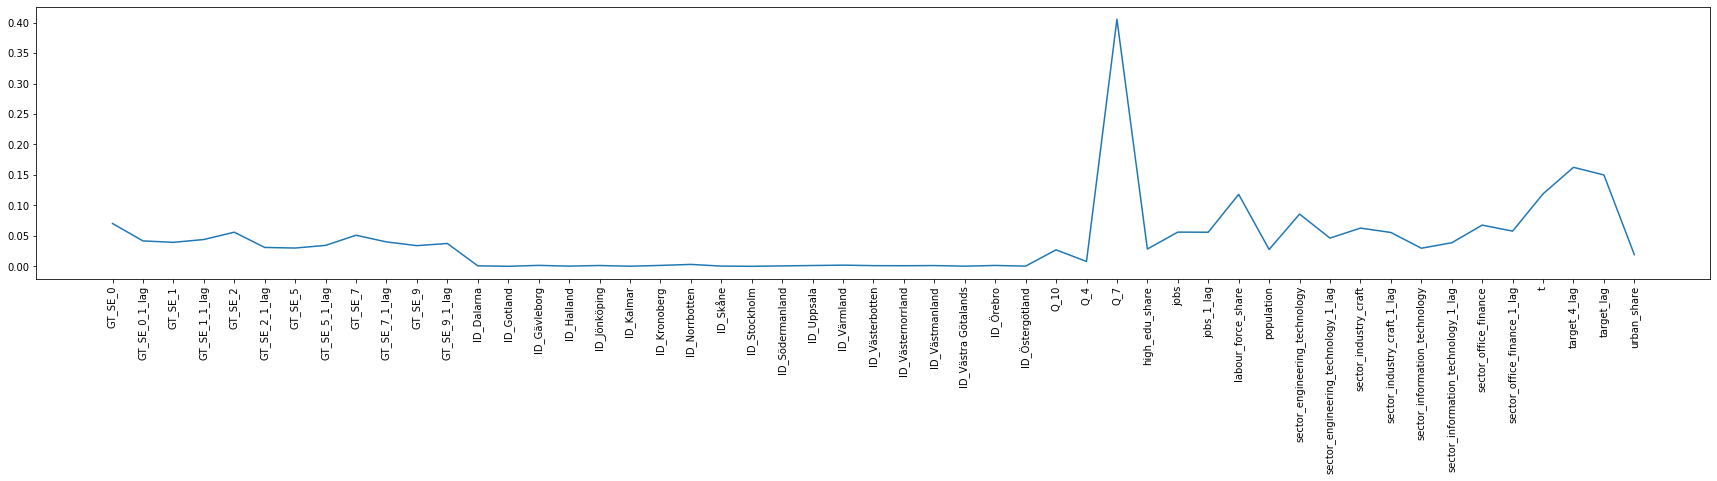

In [58]:
fig, ax = plt.subplots(figsize = (30,5))
ax.plot(df_shap.transpose().mean())

plt.xticks(rotation='vertical')

plt.show()

In [59]:
df_shap.index

Index(['GT_SE_0', 'GT_SE_0_1_lag', 'GT_SE_1', 'GT_SE_1_1_lag', 'GT_SE_2',
       'GT_SE_2_1_lag', 'GT_SE_5', 'GT_SE_5_1_lag', 'GT_SE_7', 'GT_SE_7_1_lag',
       'GT_SE_9', 'GT_SE_9_1_lag', 'ID_Dalarna', 'ID_Gotland', 'ID_Gävleborg',
       'ID_Halland', 'ID_Jönköping', 'ID_Kalmar', 'ID_Kronoberg',
       'ID_Norrbotten', 'ID_Skåne', 'ID_Stockholm', 'ID_Södermanland',
       'ID_Uppsala', 'ID_Värmland', 'ID_Västerbotten', 'ID_Västernorrland',
       'ID_Västmanland', 'ID_Västra Götalands', 'ID_Örebro', 'ID_Östergötland',
       'Q_10', 'Q_4', 'Q_7', 'high_edu_share', 'jobs', 'jobs_1_lag',
       'labour_force_share', 'population', 'sector_engineering_technology',
       'sector_engineering_technology_1_lag', 'sector_industry_craft',
       'sector_industry_craft_1_lag', 'sector_information_technology',
       'sector_information_technology_1_lag', 'sector_office_finance',
       'sector_office_finance_1_lag', 't', 'target_4_lag', 'target_lag',
       'urban_share'],
      dtype='object'

### Collapsing some variables

In [62]:
df_shap = df_shap.transpose().copy()

In [64]:
for GT in ['GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5','GT_SE_7', 'GT_SE_9']:
    df_shap[GT] = df_shap[GT] + df_shap[GT+'_1_lag']

df_shap.drop([GT+'_1_lag' for GT in ['GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5','GT_SE_7', 'GT_SE_9']], axis = 1, inplace = True)

for job in ['jobs', 'sector_engineering_technology', 'sector_industry_craft', 'sector_information_technology', 'sector_office_finance']:
    df_shap[job] = df_shap[job] + df_shap[job+'_1_lag']

df_shap.drop([job+'_1_lag' for job in ['jobs', 'sector_engineering_technology', 'sector_industry_craft', 'sector_information_technology', 'sector_office_finance']], axis = 1, inplace = True)

In [65]:
df_shap = df_shap.transpose().copy()

### Figure

In [66]:
drop_list = ['ID_Dalarna','ID_Gotland', 'ID_Gävleborg', 'ID_Halland', 'ID_Jönköping', 'ID_Kalmar',
       'ID_Kronoberg', 'ID_Norrbotten', 'ID_Skåne', 'ID_Stockholm',
       'ID_Södermanland', 'ID_Uppsala', 'ID_Värmland', 'ID_Västerbotten',
       'ID_Västernorrland', 'ID_Västmanland', 'ID_Västra Götalands',
       'ID_Örebro', 'ID_Östergötland', 'Q_10', 'Q_4', 'Q_7', 'high_edu_share', 'labour_force_share', 'population',
          'urban_share', 't']

In [67]:
sort_list = list(df_shap.drop(drop_list).transpose().mean().sort_values(ascending=False).index)

In [80]:
ylabels = ['Unemployment rate (1Y lag)', 'Unemployment rate (1Q lag)', 'Jobs: Engineering techonology', 'Jobs: Office and finance', 
           'Jobs: Industry and crafts', 'Total jobs', 'Job openings', 'Platsbanken', 'Job vacancies', 'Public unemployment services', 'Unemployment insurance benefits', 'Jobs: Information technology',
          'Cash benefits']

In [77]:
xlabels = ['2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2', 
           '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
           '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3']

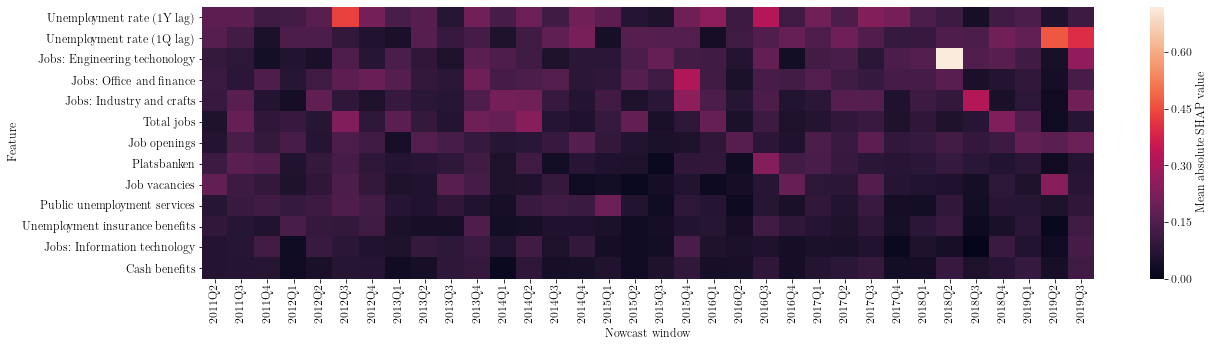

In [83]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(df_shap.drop(drop_list).reindex(sort_list), cbar_kws={'label': 'Mean absolute SHAP value'}, linecolor=None, vmin = 0,
           xticklabels=xlabels, yticklabels=ylabels)

ax.set_ylabel('Feature')
ax.set_xlabel('Nowcast window')

# #Exporting
plt.savefig("report/8_robustness/8_shap_sweden.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()